In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Waste_Data/train'

(2197, 224, 224, 3) (2197,)


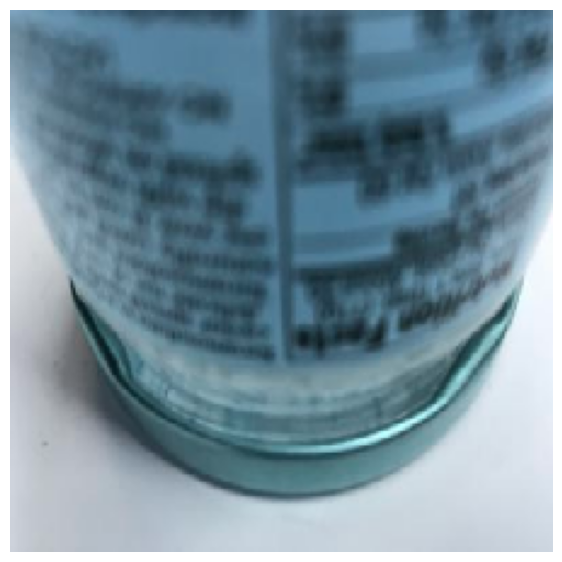

In [ ]:
dict = {
    'paper': 0,
    'plastic': 1,
    'cardboard': 2,
    'compost': 3,
    'trash': 4,
    'metal': 5,
    'glass': 6
}

train_data = []
train_labels = []
for i in os.listdir(train_path):
  dir = train_path + '/' + i
  for j in os.listdir(dir):
    img_path = dir + '/' + j
    img = cv2.imread(img_path,-1)
    img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
    train_data.append(img)
    train_labels.append(dict[i])

plt.figure(figsize=(7,10))
plt.axis('off')
plt.imshow(img)
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)

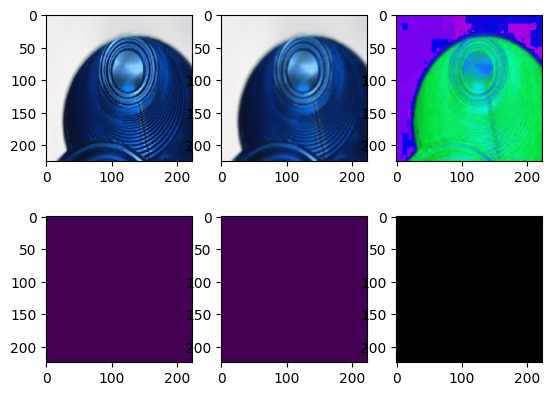

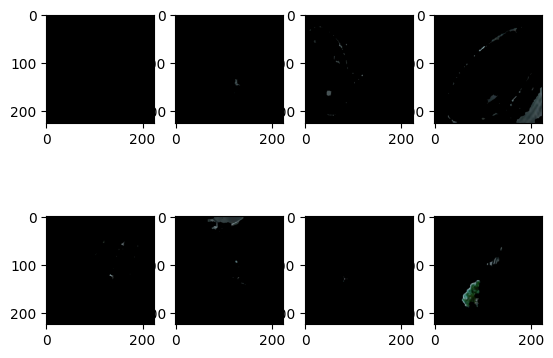

In [ ]:
new_train = []
sets = []; getEx = True
for i in train_data:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)

    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

## Training Datas Labels

In [ ]:

classes = os.listdir(train_path)
classes

['metal', 'trash', 'compost', 'cardboard', 'plastic', 'paper', 'glass']

In [ ]:
test_path = '/content/drive/MyDrive/Waste_Data/test'

In [ ]:

test_data = []
test_labels = []
classes = 7
for i in os.listdir(test_path):
    dir = test_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir + '/' + j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
        test_data.append(img)
        test_labels.append(dict[i])


test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)


(564, 224, 224, 3) (564,)


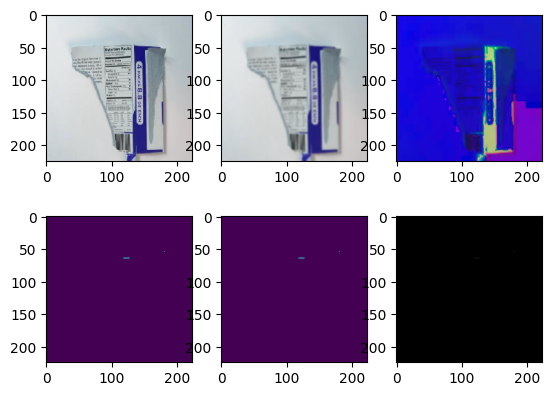

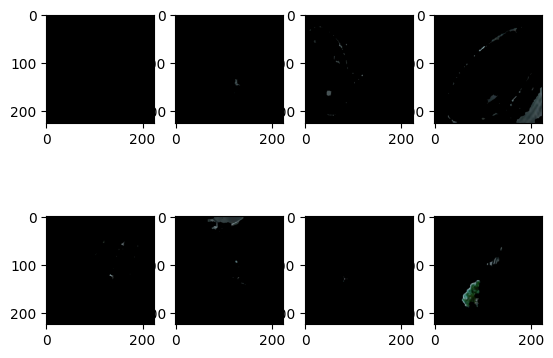

In [ ]:
new_test= []
sets = []; getEx = True
for i in test_data:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_test.append(new)

    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_test = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_test[i])

### **Data Augmentation part done on training Dataset**

In [ ]:
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
training_data = training_datagen.flow_from_directory(train_path,
                                      target_size=(224, 224),
                                      batch_size=32,
                                      class_mode='categorical')

Found 2197 images belonging to 7 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### **Data Augmentation Visualization**

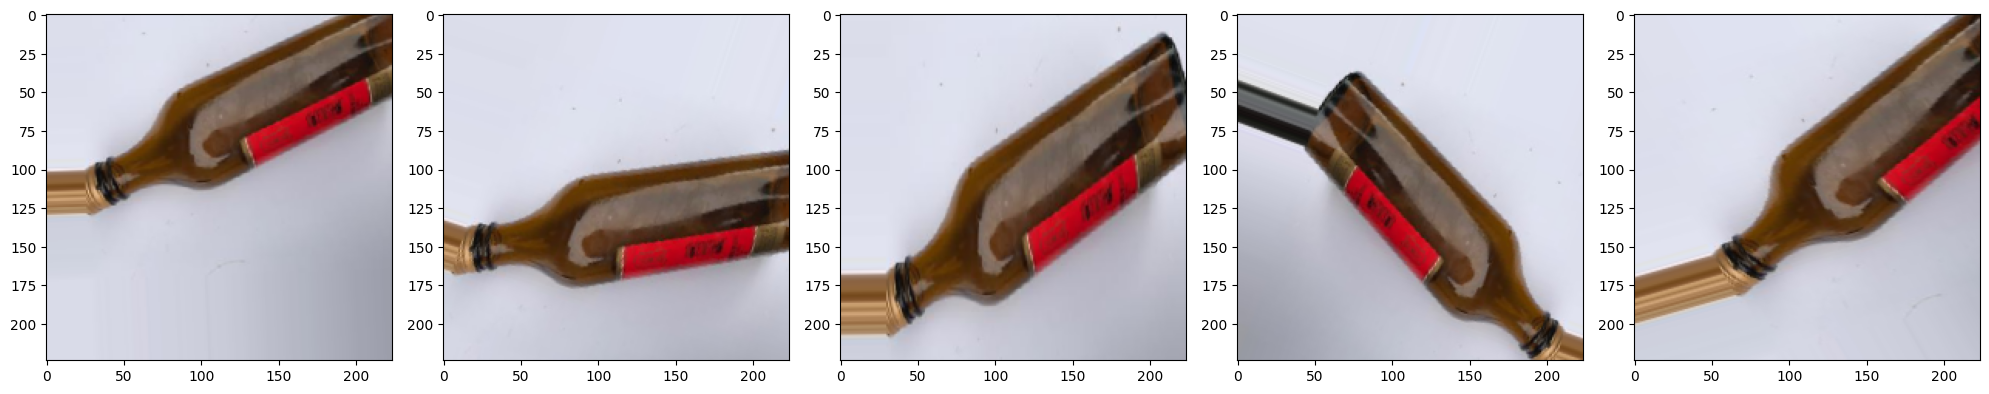

In [ ]:
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Traingn images')

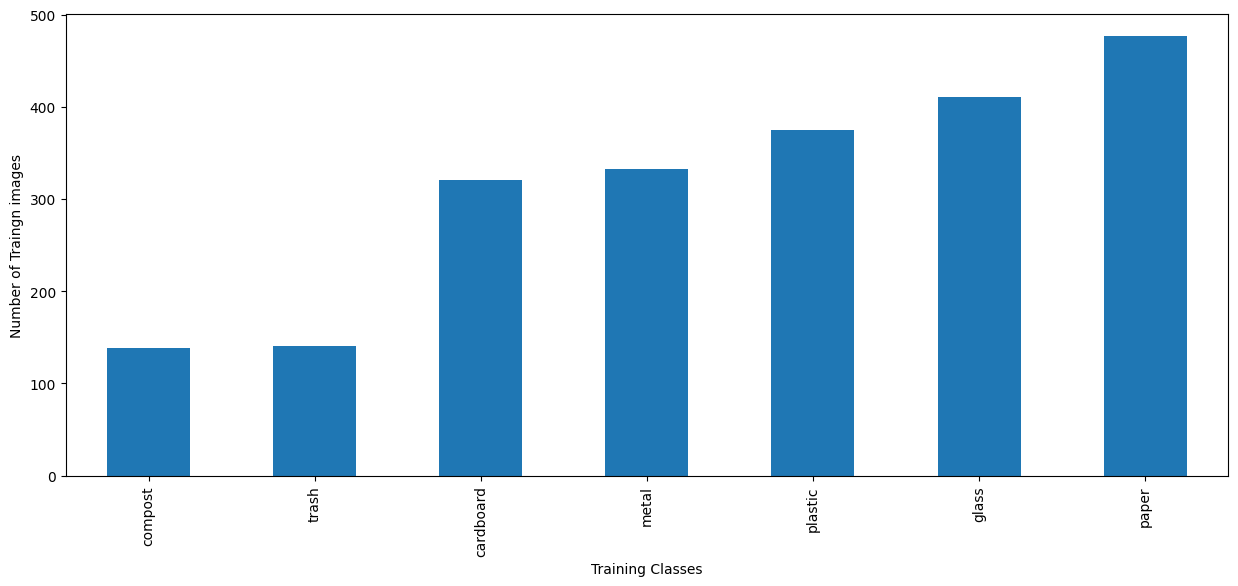

In [ ]:
data_dic = {}
for folder in os.listdir(train_path):
    data_dic[folder] = len(os.listdir(train_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Traingn images')

### **Data Augmentation part done on Testing Dataset**

In [ ]:
testing_datagen = ImageDataGenerator(rescale=1./255)

testing_data = testing_datagen.flow_from_directory(test_path,
                                      target_size=(224, 224),
                                      batch_size=32,
                                      class_mode='categorical')

Found 564 images belonging to 7 classes.


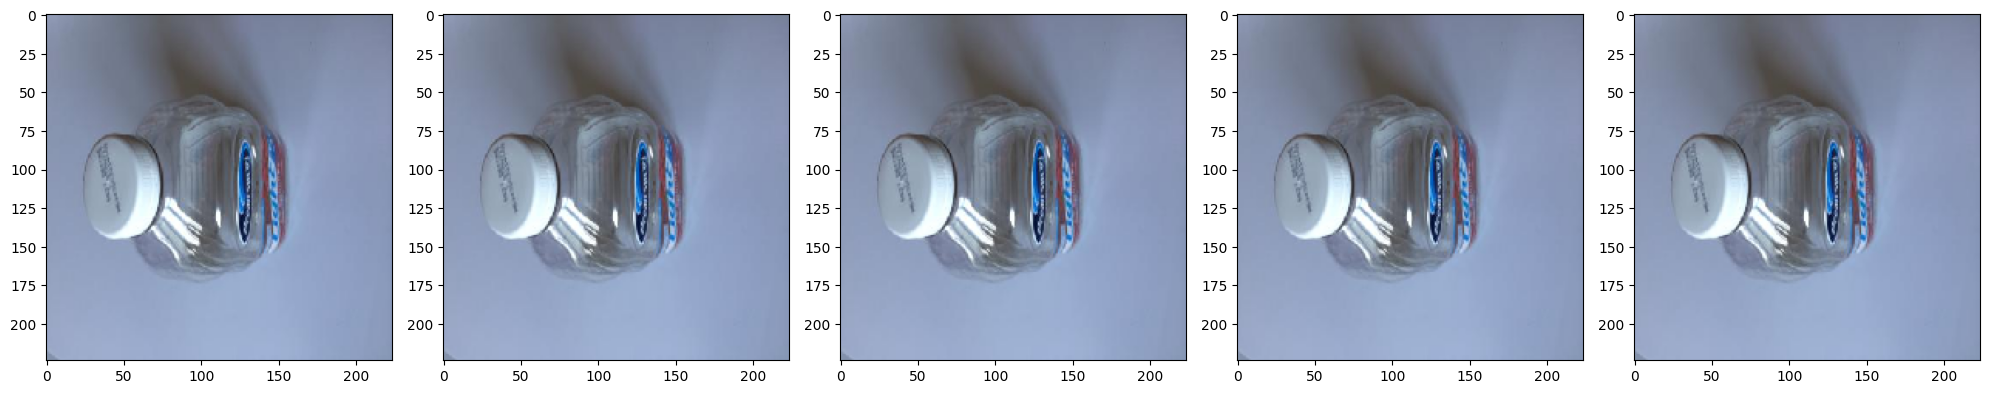

In [ ]:
images = [testing_data[1][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Valedation images')

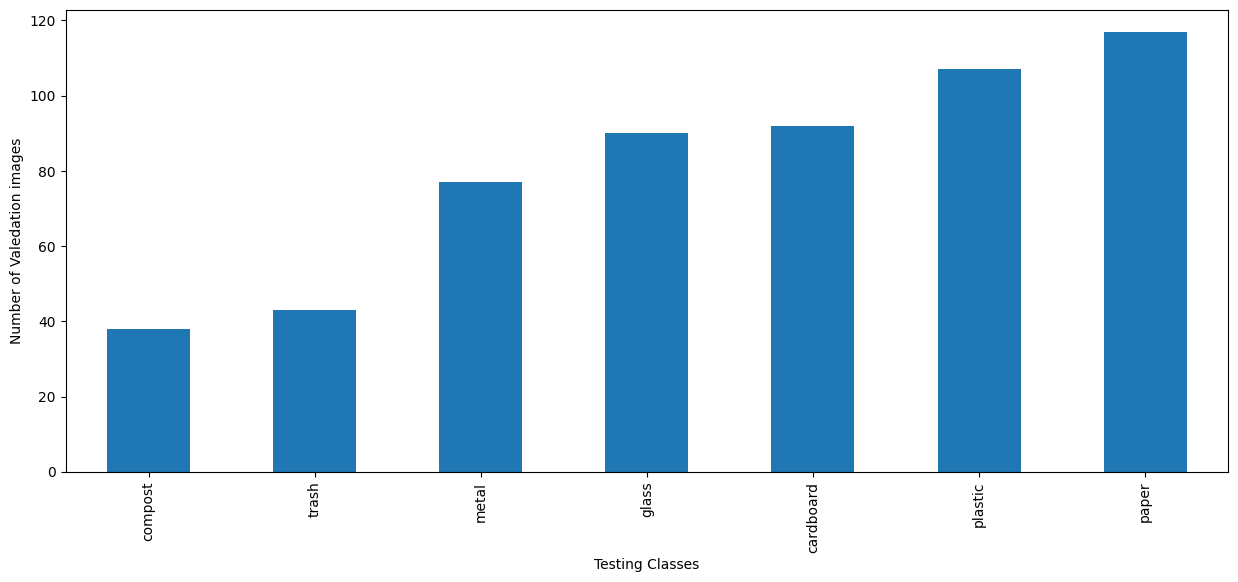

In [ ]:
data_dic = {}
for folder in os.listdir(test_path):
    data_dic[folder] = len(os.listdir(test_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Testing Classes')
plt.ylabel('Number of Valedation images')

## **CNN - VGG16 Architeture using Tranfer Learning**

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
from keras.utils import to_categorical


In [ ]:
train_labels.shape

(2197,)

In [ ]:
X_train = new_train
y_train = train_labels
X_test = new_test
y_test = test_labels


Y_train = (to_categorical(y_train))
Y_test = (to_categorical(y_test))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2197, 224, 224, 3)
(2197, 7)
(2197, 224, 224, 3)
(564, 7)


In [ ]:
base_model = VGG16(input_shape=IMAGE_SIZE + [3],weights='imagenet', include_top=False)
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
for layer in base_model.layers:
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
last = base_model.layers[-1].output
x = Flatten()(last)
prediction = Dense(len(os.listdir(train_path)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)


Layer input_1 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.


In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'vgg16_model.weights.best.hdf5',
                               verbose = False,
                               save_best_only = True)
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 4,
                           restore_best_weights = True,
                           mode = 'min')

In [ ]:
result_VGG_TF = model.fit(training_data,steps_per_epoch=len(training_data),epochs=50,callbacks=[early_stop, checkpointer],
                          validation_data=testing_data,validation_steps=len(testing_data))


Epoch 1/50
132/132 [==============================] - 54s 402ms/step - loss: 1.2468 - accuracy: 0.5730 - val_loss: 0.9311 - val_accuracy: 0.6649
Epoch 2/50
132/132 [==============================] - 52s 393ms/step - loss: 0.8718 - accuracy: 0.7000 - val_loss: 0.9158 - val_accuracy: 0.6613
Epoch 3/50
132/132 [==============================] - 52s 395ms/step - loss: 0.7715 - accuracy: 0.7353 - val_loss: 0.7223 - val_accuracy: 0.7340
Epoch 4/50
132/132 [==============================] - 52s 395ms/step - loss: 0.6943 - accuracy: 0.7638 - val_loss: 0.6830 - val_accuracy: 0.7482
Epoch 5/50
132/132 [==============================] - 52s 395ms/step - loss: 0.6849 - accuracy: 0.7674 - val_loss: 0.5922 - val_accuracy: 0.7837
Epoch 6/50
132/132 [==============================] - 52s 396ms/step - loss: 0.6385 - accuracy: 0.7755 - val_loss: 0.7825 - val_accuracy: 0.7394
Epoch 7/50
132/132 [==============================] - 52s 395ms/step - loss: 0.6076 - accuracy: 0.7921 - val_loss: 0.7784 - val_ac

'\n# We start the training\nepochs = 100\nbatch_size = 256\n# We train it\nresult_VGG_TF = model.fit(X_train, Y_train,\n                                    batch_size=batch_size,\n                                    validation_data=(X_test, Y_test),\n                                    epochs = 100)\n                                    '

In [ ]:
result_VGG_TF.lr_find(start_lr=1e-6,end_lr=1e1)
result_VGG_TF.recorder.plot()

In [ ]:
probs = model.predict(testing_data,steps = len(testing_data), verbose = 1)


18/18 [==============================] - 2s 100ms/step


In [ ]:
preds = np.argmax(probs,axis = 1)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,preds))
print(confusion_matrix(y_test,preds))

              precision    recall  f1-score   support

           0       0.15      0.14      0.14       117
           1       0.34      0.09      0.15       107
           2       0.14      0.11      0.12        92
           3       0.12      0.29      0.17        38
           4       0.11      0.35      0.16        43
           5       0.12      0.17      0.14        77
           6       0.26      0.07      0.11        90

    accuracy                           0.14       564
   macro avg       0.18      0.17      0.14       564
weighted avg       0.20      0.14      0.14       564

[[16  7  7 15 39 29  4]
 [19 10 20 13 24 15  6]
 [22  5 10 10 21 20  4]
 [ 5  0  3 11  9  9  1]
 [ 8  2  4  6 15  7  1]
 [18  1  9 22 13 13  1]
 [18  4 16 13 21 12  6]]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,preds)


cm

array([[16,  7,  7, 15, 39, 29,  4],
       [19, 10, 20, 13, 24, 15,  6],
       [22,  5, 10, 10, 21, 20,  4],
       [ 5,  0,  3, 11,  9,  9,  1],
       [ 8,  2,  4,  6, 15,  7,  1],
       [18,  1,  9, 22, 13, 13,  1],
       [18,  4, 16, 13, 21, 12,  6]])

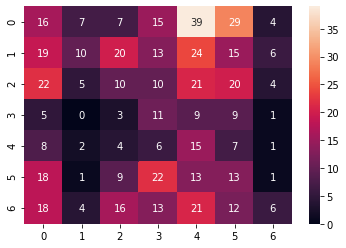

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True)
plt.savefig('h1.png')

In [ ]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,preds)
score

0.14361702127659576

In [ ]:
scores = model.evaluate(testing_data, steps = len(testing_data), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

18/18 [==============================] - 2s 116ms/step - loss: 0.5417 - accuracy: 0.8085
Test loss: 0.5417254567146301
Test accuracy: 0.8085106611251831


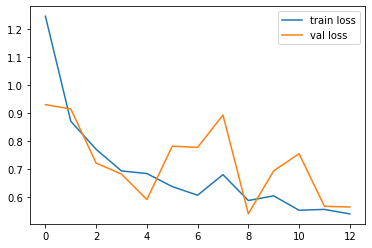

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(result_VGG_TF.history['loss'], label='train loss')
plt.plot(result_VGG_TF.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

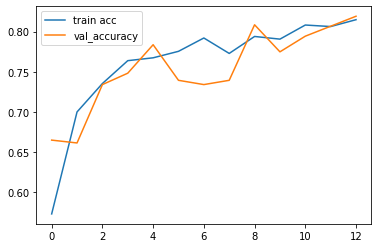

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(result_VGG_TF.history['accuracy'], label='train acc')
plt.plot(result_VGG_TF.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(testing_data)

In [ ]:
y_pred

array([[1.5374169e-09, 9.7271702e-10, 8.2858258e-01, ..., 7.1708413e-08,
        1.7119963e-01, 4.6767050e-06],
       [4.5297933e-05, 4.7902508e-14, 1.3459130e-10, ..., 9.9995470e-01,
        4.9606816e-09, 2.9414367e-11],
       [5.4733112e-04, 7.6720404e-04, 1.6194552e-03, ..., 2.3436436e-01,
        4.8258683e-01, 1.9874686e-02],
       ...,
       [1.1378409e-05, 4.1279014e-10, 7.0180207e-02, ..., 9.0043643e-05,
        9.0653339e-05, 1.3489316e-07],
       [5.7389762e-04, 5.9561990e-04, 4.2541313e-01, ..., 1.7613816e-03,
        6.2061828e-03, 7.3544062e-03],
       [9.4110928e-06, 2.9589486e-10, 7.1793735e-01, ..., 7.1306827e-06,
        1.0931374e-02, 1.7091284e-05]], dtype=float32)

In [ ]:
prediction = np.argmax(y_pred,axis =1)

In [ ]:
prediction

array([2, 4, 5, 2, 4, 0, 0, 0, 5, 4, 4, 6, 4, 3, 4, 0, 3, 3, 5, 3, 2, 6,
       2, 5, 0, 3, 6, 4, 3, 5, 4, 2, 0, 2, 5, 4, 6, 3, 1, 5, 0, 6, 1, 3,
       4, 2, 5, 4, 5, 3, 5, 1, 5, 4, 1, 5, 3, 5, 4, 3, 1, 4, 5, 3, 0, 4,
       4, 5, 0, 5, 0, 0, 0, 4, 3, 0, 3, 0, 0, 4, 0, 3, 4, 4, 4, 5, 0, 0,
       2, 4, 0, 4, 1, 4, 0, 5, 2, 1, 3, 4, 4, 4, 3, 0, 4, 5, 4, 4, 0, 3,
       4, 0, 4, 4, 2, 5, 4, 2, 1, 5, 3, 4, 5, 4, 5, 5, 4, 3, 4, 2, 5, 0,
       4, 4, 2, 5, 5, 0, 4, 4, 4, 1, 4, 4, 4, 3, 5, 4, 0, 5, 0, 0, 5, 4,
       5, 2, 6, 3, 0, 2, 4, 0, 0, 0, 0, 5, 4, 3, 4, 0, 4, 4, 0, 5, 2, 2,
       4, 3, 3, 0, 1, 3, 3, 4, 0, 3, 2, 2, 1, 5, 2, 2, 0, 2, 5, 0, 5, 5,
       4, 5, 0, 5, 5, 3, 4, 2, 0, 5, 0, 0, 2, 4, 3, 5, 2, 0, 2, 5, 2, 5,
       4, 6, 6, 5, 4, 3, 3, 0, 4, 4, 0, 5, 6, 4, 4, 0, 3, 0, 0, 2, 4, 2,
       0, 2, 5, 2, 3, 3, 1, 3, 5, 5, 2, 3, 2, 0, 6, 3, 2, 5, 6, 0, 4, 4,
       2, 5, 2, 3, 5, 3, 5, 0, 4, 0, 5, 6, 4, 5, 0, 1, 4, 1, 1, 3, 1, 4,
       5, 5, 1, 3, 4, 2, 5, 5, 4, 3, 3, 3, 1, 3, 1,

In [ ]:
rev_dict = {
    0 : 'paper',
    1 :'plastic',
    2 : 'cardboard',
    3 : 'compost',
    4 : 'trash',
    5 :'metal',
    6 : 'glass'
}

In [ ]:
rev_dict.values()

dict_values(['paper', 'plastic', 'cardboard', 'compost', 'trash', 'metal', 'glass'])

In [ ]:
rev_dict.values()

In [ ]:
y_hat_pred = []
for i in prediction:
  y_hat_pred.append(rev_dict[i])

In [ ]:
y_hat_pred

['cardboard',
 'trash',
 'metal',
 'cardboard',
 'trash',
 'paper',
 'paper',
 'paper',
 'metal',
 'trash',
 'trash',
 'glass',
 'trash',
 'compost',
 'trash',
 'paper',
 'compost',
 'compost',
 'metal',
 'compost',
 'cardboard',
 'glass',
 'cardboard',
 'metal',
 'paper',
 'compost',
 'glass',
 'trash',
 'compost',
 'metal',
 'trash',
 'cardboard',
 'paper',
 'cardboard',
 'metal',
 'trash',
 'glass',
 'compost',
 'plastic',
 'metal',
 'paper',
 'glass',
 'plastic',
 'compost',
 'trash',
 'cardboard',
 'metal',
 'trash',
 'metal',
 'compost',
 'metal',
 'plastic',
 'metal',
 'trash',
 'plastic',
 'metal',
 'compost',
 'metal',
 'trash',
 'compost',
 'plastic',
 'trash',
 'metal',
 'compost',
 'paper',
 'trash',
 'trash',
 'metal',
 'paper',
 'metal',
 'paper',
 'paper',
 'paper',
 'trash',
 'compost',
 'paper',
 'compost',
 'paper',
 'paper',
 'trash',
 'paper',
 'compost',
 'trash',
 'trash',
 'trash',
 'metal',
 'paper',
 'paper',
 'cardboard',
 'trash',
 'paper',
 'trash',
 'plasti

**Fine**-**tuning** **on** **VGG16**

In [ ]:
for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    break
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(len(os.listdir(train_path)), activation='softmax', name='predictions')(x)
model_Res = Model(base_model.input, x)
model_Res.compile(optimizer=Adam(lr=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])
model_Res.summary()

Layer input_4 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
result_Res_FT = model_Res.fit(training_data,steps_per_epoch=len(training_data),epochs=50,callbacks=[early_stop, checkpointer],
                              validation_data=testing_data,validation_steps=len(testing_data))


Epoch 1/50
132/132 [==============================] - 54s 401ms/step - loss: 1.4081 - accuracy: 0.5360 - val_loss: 0.9245 - val_accuracy: 0.6365
Epoch 2/50
132/132 [==============================] - 52s 397ms/step - loss: 0.9284 - accuracy: 0.6613 - val_loss: 0.8480 - val_accuracy: 0.6791
Epoch 3/50
132/132 [==============================] - 53s 398ms/step - loss: 0.8402 - accuracy: 0.6962 - val_loss: 0.7467 - val_accuracy: 0.7181
Epoch 4/50
132/132 [==============================] - 54s 409ms/step - loss: 0.7766 - accuracy: 0.7149 - val_loss: 0.7922 - val_accuracy: 0.7074
Epoch 5/50
132/132 [==============================] - 55s 413ms/step - loss: 0.7327 - accuracy: 0.7365 - val_loss: 0.6970 - val_accuracy: 0.7429
Epoch 6/50
132/132 [==============================] - 53s 398ms/step - loss: 0.6973 - accuracy: 0.7529 - val_loss: 0.6562 - val_accuracy: 0.7660
Epoch 7/50
132/132 [==============================] - 53s 398ms/step - loss: 0.6441 - accuracy: 0.7731 - val_loss: 0.5695 - val_ac

In [ ]:
probs = model_Res.predict(testing_data,steps = len(testing_data), verbose = 1)
preds = np.argmax(probs,axis = 1)

18/18 [==============================] - 2s 98ms/step


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,preds))
print(confusion_matrix(y_test,preds))

              precision    recall  f1-score   support

           0       0.24      0.18      0.20       117
           1       0.21      0.08      0.12       107
           2       0.13      0.09      0.10        92
           3       0.03      0.08      0.04        38
           4       0.09      0.28      0.14        43
           5       0.12      0.16      0.13        77
           6       0.08      0.03      0.05        90

    accuracy                           0.12       564
   macro avg       0.13      0.13      0.11       564
weighted avg       0.15      0.12      0.12       564

[[21  7 15 22 24 22  6]
 [11  9 10 19 27 22  9]
 [13 11  8 19 20 16  5]
 [ 8  2  7  3  8  4  6]
 [ 8  1  4  9 12  9  0]
 [16  5  6 11 19 12  8]
 [11  8 12 14 23 19  3]]
